### Import Required Libraries
---

In [2]:
import os
import random
import time
import platform
import requests

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn, optim

from torch.optim import lr_scheduler

from torchvision import transforms, models, datasets, utils

### Work in Colab or Local

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Debug
print(IN_COLAB)

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

False


### Model Architectures
---

In [4]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = models.mobilenet_v2(pretrained=True)
    self.freeze()

    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, output_size),
        nn.LogSoftmax(1)
    )

  def forward(self, x):
    return self.mnet(x)

  def freeze(self):
    # Freeze all
    for param in self.mnet.parameters():
      param.requires_grad = False

    # Unfreeze the last block
    for param in self.mnet.features[-3:].parameters():
        param.requires_grad = True

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(device))


Device: cpu


### Model Architecture Definition
---

In [6]:
ARCH_NAME = 'resnet18'

if ARCH_NAME == 'simplenet':
    # Simple net
    model = Net(3, 5)

elif ARCH_NAME == 'alexnet':
    # Pretrainned
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
    ### model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # Changes the number of neurons in the output layer.
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 5)

elif ARCH_NAME == 'resnet18':
    model = models.resnet18(pretrained=True).to(device)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 5).to(device)

elif ARCH_NAME == 'mobilenetv2':
    model = CustomMobileNetv2(output_size=5).to(device)

# Include more architectures...
# ---
### elif ARCH_NAME == ...

c:\Users\Samuel Oliveira\Desktop\CS\deep-learning-notebooks\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Samuel Oliveira\Desktop\CS\deep-learning-notebooks\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Load Model From Path
---

In [18]:
if IN_COLAB:
    ds_path = '/content/drive/My Drive/Data/faces-emotion-recognition/faces/'
else:
    model_path = '../model/exp-fer_p3_01/'
    ds_path = '../data/'

In [ ]:
checkpoint = torch.load(
    os.path.join(model_path, f"fer-classification-{ARCH_NAME}-model.pth"),
    map_location=torch.device('cpu')   # força carregar para CPU
)

model.load_state_dict(checkpoint)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Model Parameters
---

In [11]:
# Calculate and print the total number of trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_trainable_params}")


Total trainable parameters: 11179077


### Define data transform

In [15]:
data_transform = transforms.Compose([
    # It is necessary to resize the image to match the network's input size.
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # Mean and standard deviation of ImageNet
    # These are required as we will use a model pre-trained on ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Create Test Loader for Model Inference

In [19]:
batch_size = 64
test_set = datasets.ImageFolder(ds_path+'test', transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [20]:
classes = test_set.classes

print('Number of Test Samples: ', len(test_set))
print('Number of classes: ', len(test_set.classes))
print('Number of batches: ', (test_loader.batch_size))
print('Number of iteration per batches: ', round(len(test_set) // test_loader.batch_size))
print('Classes: ', test_set.classes)

Number of Test Samples:  3150
Number of classes:  5
Number of batches:  64
Number of iteration per batches:  49
Classes:  ['angry', 'fear', 'happy', 'neutral', 'sad']


### GPU Pre-Heating

In [21]:
# Pré-aquecimento da GPU (só se tiver CUDA disponível)
if device.type == "cuda":
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224, device=device)
        _ = model(dummy)

### Convert images from test_loader tensor to numpy array for visualization
---

In [22]:
def images_tensor_to_array(image_tensor):
  images_list = []
  # Example mean and std used in normalization (for ImageNet pretrained models)
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  for i in range(len(image_tensor)):
    image_array = image_tensor[i].numpy()          # Convert tensor to numpy
    image_array = image_array.transpose(1, 2, 0)     # (C, H, W) -> (H, W, C)

    # Unnormalize
    image_array = std * image_array + mean
    image_array = np.clip(image_array, 0, 1)         # Clip to [0, 1] range

    images_list.append(image_array)

  return images_list

### Model Test
---

In [24]:
labels_true = []
labels_pred = []

images_list = []

model.eval()

with torch.no_grad():
  for images, labels in tqdm(test_loader):
    # append images tensor to list before movindo to GPU
    images_list.extend(images_tensor_to_array(images))

    # move image and labels to GPU
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

    pred = outputs.data.max(1, keepdim=True)[1]

    # print('Outputs : ', outputs.cpu().numpy())
    # print('Labels: ', labels.cpu().numpy())

    labels_pred.extend(outputs.cpu().numpy())
    labels_true.extend(labels.cpu().numpy())

labels_pred = np.array(labels_pred)
labels_true = np.array(labels_true)

100%|██████████| 50/50 [02:16<00:00,  2.74s/it]


### Confusion Matrix
---

In [25]:
# Get the index of max probabilities
labels_pred_argmax = np.argmax(labels_pred, axis=1)
print('Number of labels: ', len(labels_pred_argmax))
print('Number of images: ', len(images_list))

print("True Labels: ", labels_true[:10])
print("True Labels: ", labels_pred_argmax[:10])

Number of labels:  3150
Number of images:  3150
True Labels:  [2 3 4 2 4 1 4 4 2 2]
True Labels:  [2 4 4 1 0 1 4 4 2 2]


In [26]:
cm = metrics.confusion_matrix(labels_true, labels_pred_argmax)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[266  43   9  38  62]
 [ 70 433  19  78 123]
 [ 15  16 770  61  19]
 [ 26  29  43 328  93]
 [ 57  79  27  94 352]]


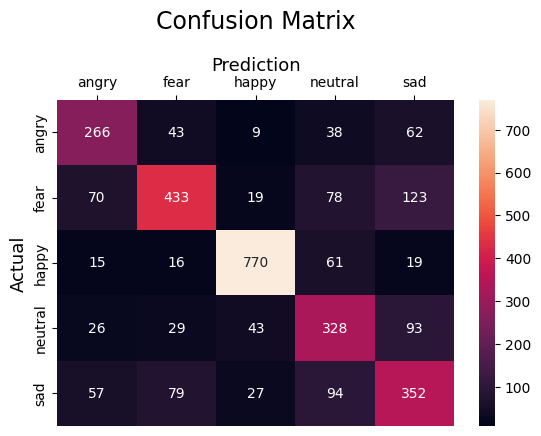

In [27]:
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=classes,
            yticklabels=classes)
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

### Classification Report
---

In [28]:
cr = metrics.classification_report(y_true=labels_true, y_pred=labels_pred_argmax, target_names=classes)
print("Classification Report")
print(cr)

Classification Report
              precision    recall  f1-score   support

       angry       0.61      0.64      0.62       418
        fear       0.72      0.60      0.65       723
       happy       0.89      0.87      0.88       881
     neutral       0.55      0.63      0.59       519
         sad       0.54      0.58      0.56       609

    accuracy                           0.68      3150
   macro avg       0.66      0.66      0.66      3150
weighted avg       0.69      0.68      0.68      3150



True fear
Pred fear


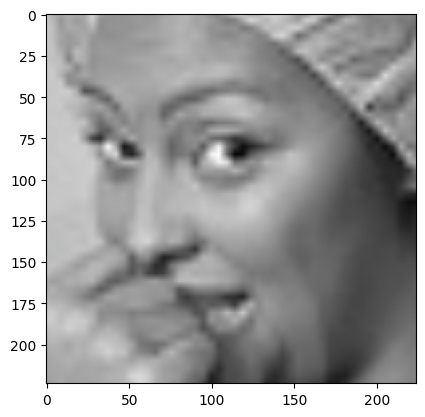

In [29]:
class_mapping = ['angry', 'fear', 'happy', 'neutral', 'sad']

print('True', class_mapping[labels_true[5]])
print('Pred', class_mapping[labels_pred_argmax[5]])
plt.imshow(images_list[5])

### Visualization
---

In [30]:
import math

def plot_classification_result(images, labels_true, labels_pred=None):

  class_mapping = ['angry', 'fear', 'happy', 'neutral', 'sad']

  n_images = len(images)
  n_cols = 6
  n_rows = 8

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
  axes = axes.flatten()  # Flatten in case n_rows > 1

  for i in range(n_rows * n_cols):
    if i < len(images):
        img = images[i]

    axes[i].imshow(images[i])
    title = f"True: {class_mapping[labels_true[i]]}"

    if labels_pred[i] == labels_true[i]:
      title += f"\nPred: {class_mapping[labels_pred[i]]}"
      color = 'green'
    else:
      title += f"\nPred: {class_mapping[labels_pred[i]]}"
      color = 'red'


    # if labels_pred is not None:
    #     title += f"\nPred: {class_mapping[labels_pred[i]]}"
    #     # Color title based on correctness
    #     color = 'green' if labels_pred[i] == labels_true[i] else 'red'
    # else:
    #     color = 'black'

    axes[i].set_title(title, color=color)
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()


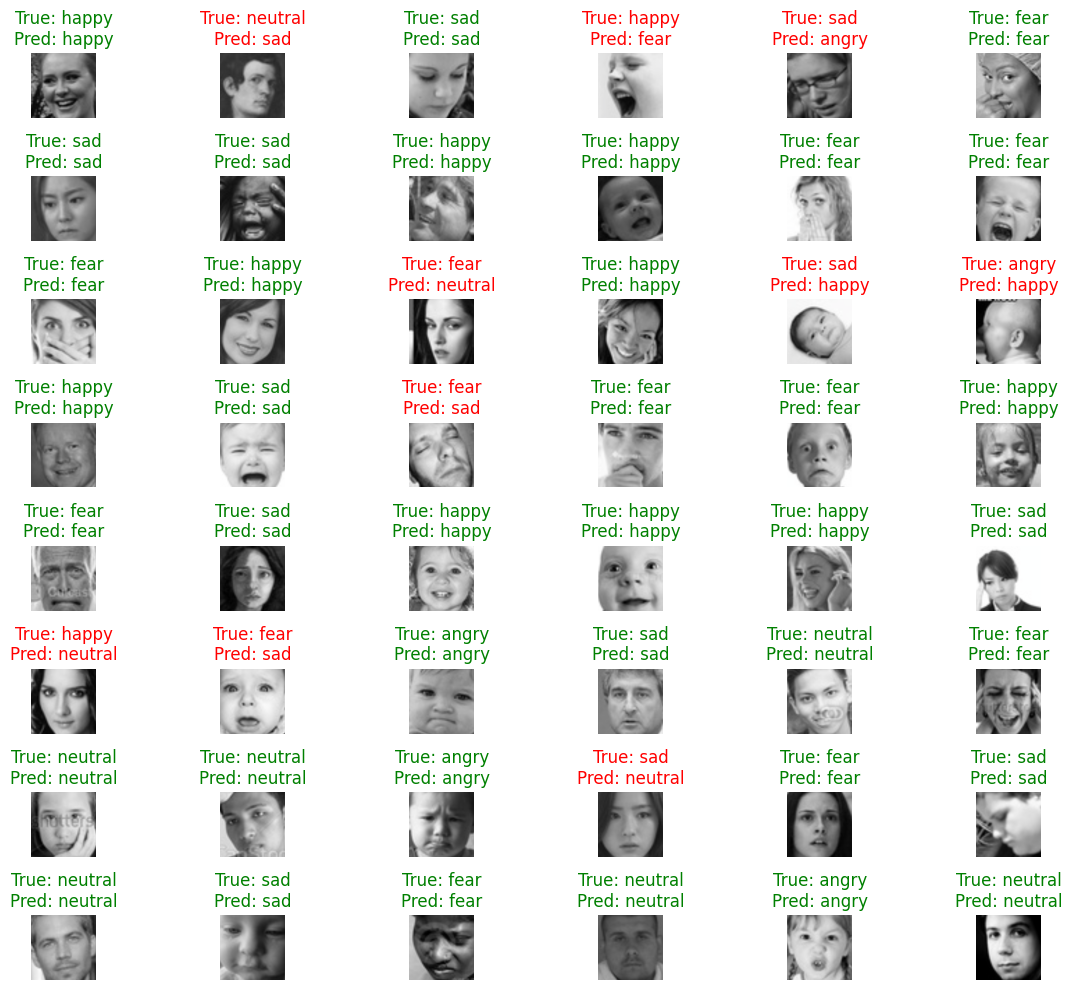

In [31]:
plot_classification_result(images_list, labels_true, labels_pred_argmax)

### Image Inference
---

In [32]:
# Load your image
image_url = "https://i.guim.co.uk/img/static/sys-images/Guardian/Pix/pictures/2008/06/15/fear460.jpg?width=465&dpr=1&s=none&crop=none"
# image = Image.open(image_path).convert("RGB") # Ensure RGB format
image = Image.open(requests.get(image_url, stream=True).raw)

# Apply the transform
transformed_image = data_transform(image)

# Add a batch dimension if your model expects batched input
# (e.g., for a single image, shape will be [1, C, H, W])
input_tensor = transformed_image.unsqueeze(0)

In [33]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [34]:
input_tensor = input_tensor.to(device)

In [35]:
class_mapping = [
    "angry",
    "fear",
    "happy",
    "neutral",
    "sad"
]

In [36]:
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_index = torch.argmax(output, dim=1).item()

    print(output)
print("Predicted class:", class_mapping[predicted_index])

tensor([[-2.4974,  7.4027, -7.6661, -7.8805, -9.0141]])
Predicted class: fear
